# Tutorial: fitting a BL Lac broad-band SED using angpy and Gammapy

In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `Gammapy` wrapper.
A [Gammapy's `SpectralModel`](https://docs.gammapy.org/0.20/api/gammapy.modeling.models.SpectralModel.html) representing several radiative processes can be defined, and used either to fit flux points or to perform a forward-folding likelihood fit (if the instrument response is available in a format compatible with `Gammapy`). 

Several combination of radiative processes can be used to model the broad-band emission of a jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:
* `SycnhrotronSelfComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation. This scenario is commonly considered to model BL Lac sources.
* `ExternalComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation along with an external Compton component that can be computed over a list of targets. This scenario is commonly considered to model flat spectrum radio quasars.


In this tutorial we will show how to use the `SynchrotronSelfComptonSpectralModel` to fit the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import c
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.wrappers import SynchrotronSelfComptonSpectralModel
from agnpy.wrappers import add_systematic_errors_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import (SPECTRAL_MODEL_REGISTRY, SkyModel)
from gammapy.estimators import FluxPoints
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(SynchrotronSelfComptonSpectralModel)

### `gammapy` wrapper of agnpy synchrotron and SSC
The definition of the `SynchrotronSelfComptonSpectralModel` follows the normal definition of radiative processes in agnpy (see for example the [Synchrotron and SSC tutorial](./synchrotron_self_compton.ipynb)). Therefore only a blob instance is needed to initialise the model.

In [2]:
# total energy content of the electron distribution
spectrum_norm = 1.5e-8 * u.Unit("cm-3") 
# EED parameters
spectrum_dict = {
    "type": "BrokenPowerLaw", 
    "parameters": {
        "p1": 2.0,
        "p2": 3.5,
        "gamma_b": 1e5,
        "gamma_min": 500, 
        "gamma_max": 1e6
    }
}
# blob parameters
B = 0.05 * u.G
z = 0.0308
delta_D = 18
Gamma = 18
# assume a blob with a radius corresponding to a t_var = 1 day
t_var = 1 * u.d
R_b = c * t_var * delta_D / (1 + z)

# emission region
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict, spectrum_norm_type="differential")

In [3]:
# model
ssc_model = SynchrotronSelfComptonSpectralModel(blob)

In [4]:
print(ssc_model.parameters.to_table())

  type      name     value    unit   error      min       max    frozen is_norm link
-------- --------- ---------- ---- --------- --------- --------- ------ ------- ----
spectral       k_e 1.5000e-08 cm-3 0.000e+00 1.000e-10 1.000e+02  False   False     
spectral        p1 2.0000e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral        p2 3.5000e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral   gamma_b 1.0000e+05      0.000e+00 1.000e+02 1.000e+06  False   False     
spectral gamma_min 5.0000e+02      0.000e+00 1.000e+00 1.000e+03   True   False     
spectral gamma_max 1.0000e+06      0.000e+00 1.000e+05 1.000e+08   True   False     
spectral         z 3.0800e-02      0.000e+00 1.000e-03 1.000e+01   True   False     
spectral       d_L 4.3094e+26   cm 0.000e+00 1.368e+25 3.271e+29   True   False     
spectral   delta_D 1.8000e+01      0.000e+00 1.000e+00 1.000e+02  False   False     
spectral         B 5.0000e-02    G 0.000e+00 1.000e-04 1.000e+03 

In [5]:
print(ssc_model.spectral_parameters.to_table())

  type      name     value    unit   error      min       max    frozen is_norm link
-------- --------- ---------- ---- --------- --------- --------- ------ ------- ----
spectral       k_e 1.5000e-08 cm-3 0.000e+00 1.000e-10 1.000e+02  False   False     
spectral        p1 2.0000e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral        p2 3.5000e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral   gamma_b 1.0000e+05      0.000e+00 1.000e+02 1.000e+06  False   False     
spectral gamma_min 5.0000e+02      0.000e+00 1.000e+00 1.000e+03   True   False     
spectral gamma_max 1.0000e+06      0.000e+00 1.000e+05 1.000e+08   True   False     


In [6]:
print(ssc_model.emission_region_parameters.to_table())

  type     name    value    unit   error      min       max    frozen is_norm link
-------- ------- ---------- ---- --------- --------- --------- ------ ------- ----
spectral       z 3.0800e-02      0.000e+00 1.000e-03 1.000e+01   True   False     
spectral     d_L 4.3094e+26   cm 0.000e+00 1.368e+25 3.271e+29   True   False     
spectral delta_D 1.8000e+01      0.000e+00 1.000e+00 1.000e+02  False   False     
spectral       B 5.0000e-02    G 0.000e+00 1.000e-04 1.000e+03  False   False     
spectral   t_var 1.0000e+00    d 0.000e+00 1.000e-02 1.000e+02   True   False     


### Fit with `gammapy`
Here we start the procedure to fit with `Gammapy`.

#### 1) load the MWL flux points 
The MWL SEDs included in the default `agnpy` data are automatically readable by `Gammapy`'s `FluxPoints`

In [7]:
datasets = Datasets()
flux_points = {}

sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
table = Table.read(sed_path)
table = table.group_by("instrument")

# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())

for group in table.groups:
    name = group["instrument"][0]
    
    data = FluxPoints.from_table(group, sed_type="e2dnde", format="gadf-sed")
    dataset = FluxPointsDataset(data=data, name=name)
    
    flux_points.update({name: data})
    dataset.mask_fit = dataset.data.energy_ref > E_min_fit
    datasets.append(dataset)

# load the SSC model in the datasets
model = SkyModel(spectral_model = ssc_model, name="Mrk421")
datasets.models = [model]

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

#### 2) add systematic errors
Currently there is no function in `gammapy` handling systematic errors on flux points.    
Let us manually add different systematic errors in different energy bands.     
We assume them to be independent from the statistical ones and sum the two in quadrature.

In [8]:
# add systematic errors
for key in flux_points.keys():
    if key == "MAGIC":
        add_systematic_errors_flux_points(flux_points[key], 0.30)
    elif key in ["Fermi", "RXTE/PCA", "Swift/BAT", "Swift/XRT"]:
        add_systematic_errors_flux_points(flux_points[key], 0.10)
    else:
        add_systematic_errors_flux_points(flux_points[key], 0.05)                 

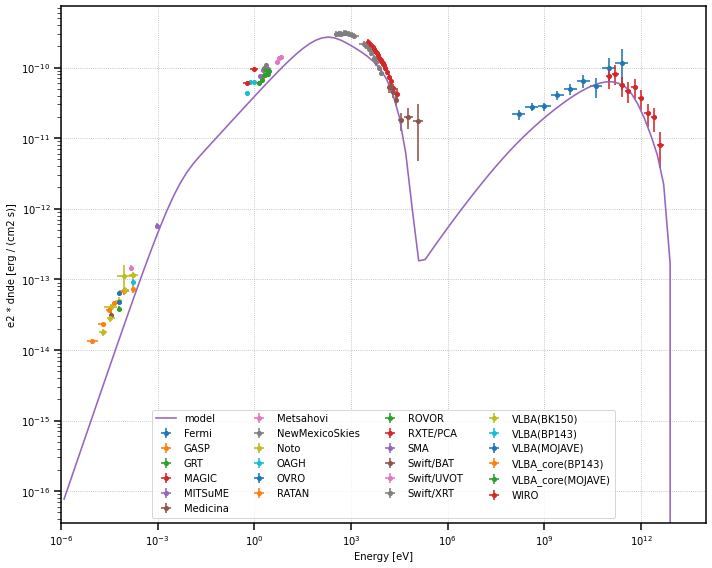

In [9]:
# plot the starting model and the flux points
load_mpl_rc()
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model")
    
plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()

In [10]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)

CPU times: user 23min 38s, sys: 173 ms, total: 23min 38s
Wall time: 23min 38s


In [11]:
print(results)
print(model.spectral_model.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Call limit was reached.
	nfev       : 1277
	total stat : 640.95

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

  type      name     value    unit   error      min       max    frozen is_norm link
-------- --------- ---------- ---- --------- --------- --------- ------ ------- ----
spectral       k_e 3.3763e-07 cm-3 2.312e-08 1.000e-10 1.000e+02  False   False     
spectral        p1 1.9437e+00      2.906e-02 1.000e+00 5.000e+00  False   False     
spectral        p2 3.3628e+00      1.562e-02 1.000e+00 5.000e+00  False   False     
spectral   gamma_b 3.8389e+04      1.132e+03 1.000e+02 1.000e+06  False   False     
spectral gamma_min 5.0000e+02      0.000e+00 1.000e+00 1.000e+03   True   False     
spectral gamma_max 1.0000e+06      0.000e+00 1.000e+05 1.000e+08   True   False     
spectral         z

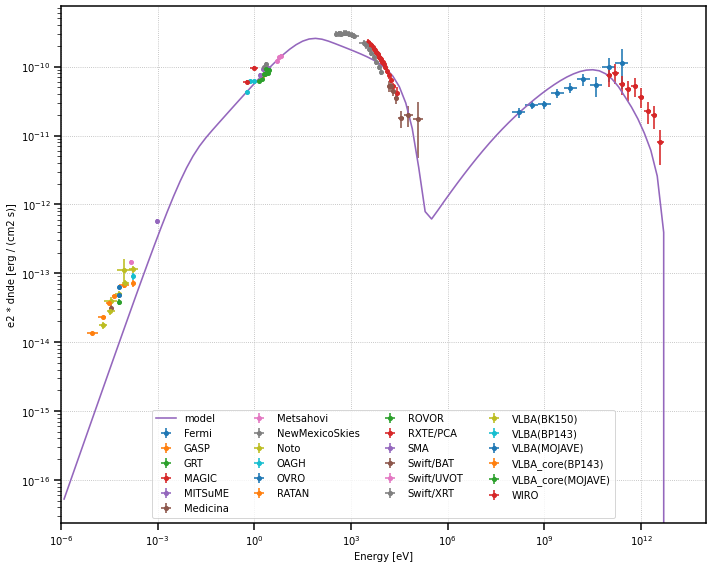

In [12]:
# plot the final model and the flux points
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model")
    
plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()